In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pour le modèle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# pour l'ingénierie des fonctionnalités
from feature_engine import imputation as mdi
from feature_engine import discretisation  as dsc
from feature_engine import transformation as ce

In [8]:
cols = [
    'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
    'embarked', 'survived'
]

data = pd.read_csv('./Data/titanic.csv', usecols=cols)

data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B5,S
1,1,1,male,0.9167,1,2,151.5500,C22,S
2,1,0,female,2.0000,1,2,151.5500,C22,S
3,1,0,male,30.0000,1,2,151.5500,C22,S
4,1,0,female,25.0000,1,2,151.5500,C22,S


In [10]:
data.nunique()

pclass        3
survived      2
sex           2
age          98
sibsp         7
parch         8
fare        281
cabin       181
embarked      3
dtype: int64

In [11]:
data.value_counts()

pclass  survived  sex     age   sibsp  parch  fare      cabin  embarked
1       1         female  24.0  0      0      69.3000   B35    C           2
        0         female  2.0   1      2      151.5500  C22    S           1
        1         female  58.0  0      0      26.5500   C103   S           1
                          60.0  1      0      75.2500   D37    C           1
                                0      0      76.2917   D15    C           1
                                                                          ..
                          19.0  1      0      91.0792   B49    C           1
                          21.0  0      0      77.9583   D9     S           1
                                2      2      262.3750  B57    C           1
                          22.0  0      1      55.0000   E33    S           1
3       1         male    32.0  0      0      8.0500    E10    S           1
Length: 269, dtype: int64

Faire une liste de types de variables

In [12]:
# numérique: discret vs continu
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='survived' and data[var].nunique()<10]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='survived' and var not in discrete]

# mixte
mixed = ['cabin']

# catégorique
categorical = [var for var in data.columns if data[var].dtype=='O' and var not in mixed]

print('Il y a {} variables discrètes'.format(len(discrete)))
print('Il y a {} variables continues'.format(len(continuous)))
print('Il y a {} variables catégorielles'.format(len(categorical)))
print('Il y a {} variables mixtes'.format(len(mixed)))

Il y a 3 variables discrètes
Il y a 2 variables continues
Il y a 2 variables catégorielles
Il y a 1 variables mixtes


In [13]:
data.isnull().mean()

pclass      0.000000
survived    0.000000
sex         0.000000
age         0.200917
sibsp       0.000000
parch       0.000000
fare        0.000764
cabin       0.774637
embarked    0.001528
dtype: float64

In [14]:
## cardinalité 
data[categorical+mixed].nunique()

sex           2
embarked      3
cabin       181
dtype: int64

<AxesSubplot: >

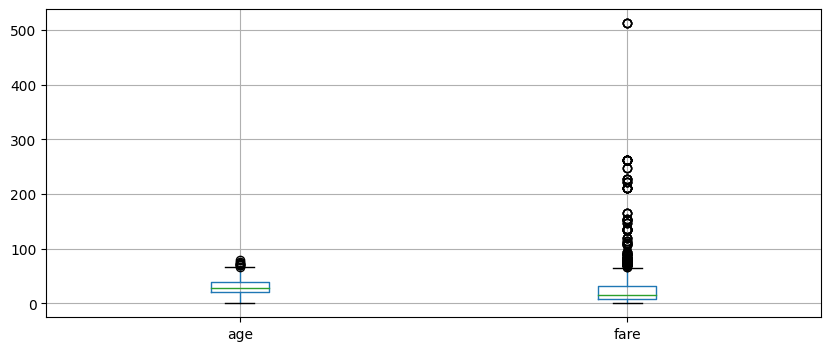

In [15]:
### valeurs abérrantes
data[continuous].boxplot(figsize=(10,4))

In [16]:
# valeurs aberrantes en discret
data[discrete].boxplot(figsize=(10,4))

<AxesSubplot: >

In [17]:
# les valeurs supérieures à 3 sont rares pour le parch
data['parch'].value_counts()

0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: parch, dtype: int64

In [18]:
data.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [19]:
## Ingénierie de type mixte de variables¶
## Extraire des parties numériques et catégoriques de variables.
# Cabin
data['cabin_num'] = data['cabin'].str.extract('(\d+)') # partie numérique
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['cabin'].str[0] # la première lettre

# dataframe
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,cabin_num,cabin_cat
0,1,1,female,29.0000,0,0,211.3375,B5,S,5.0,B
1,1,1,male,0.9167,1,2,151.5500,C22,S,22.0,C
2,1,0,female,2.0000,1,2,151.5500,C22,S,22.0,C
3,1,0,male,30.0000,1,2,151.5500,C22,S,22.0,C
4,1,0,female,25.0000,1,2,151.5500,C22,S,22.0,C


In [20]:
data.drop(['cabin'], axis=1, inplace=True)

In [21]:
##Séparer l'ensemble de données en train set et test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # prédicteurs
    data['survived'],  # cible
    test_size=0.1,  # pourcentage d'observations dans l'ensemble de test
    random_state=0)  #pour assurer la reproductibilité

X_train.shape, X_test.shape

((1178, 9), (131, 9))

In [22]:
## Imputation
# numérique

X_train.select_dtypes(exclude='O').isnull().mean()

pclass       0.000000
age          0.198642
sibsp        0.000000
parch        0.000000
fare         0.000849
cabin_num    0.782683
dtype: float64

In [23]:
# catégorique

X_train.select_dtypes(include='O').isnull().mean()

sex          0.000000
embarked     0.001698
cabin_cat    0.771647
dtype: float64

In [24]:
# vérifier à nouveau la cardinalité

X_train[['cabin_cat', 'sex', 'embarked']].nunique()

cabin_cat    8
sex          2
embarked     3
dtype: int64

In [25]:
# vérifier la fréquence variable

var = 'cabin_cat'
(X_train[var].value_counts() / len(X_train)).sort_values()

T    0.000849
G    0.003396
A    0.016978
F    0.016978
E    0.033107
D    0.033956
B    0.049236
C    0.073854
Name: cabin_cat, dtype: float64

### Discrétisation ou transf de variables


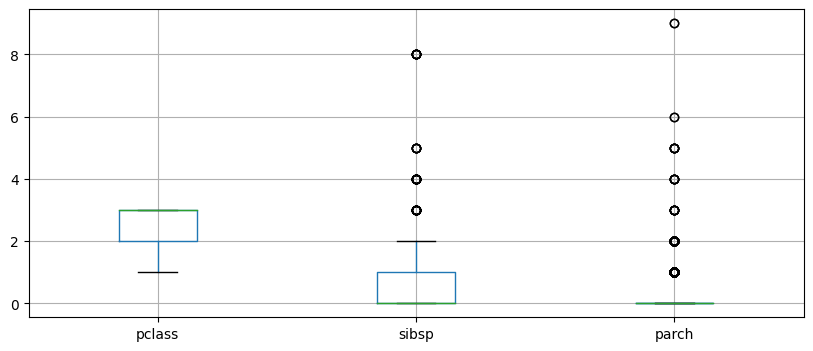

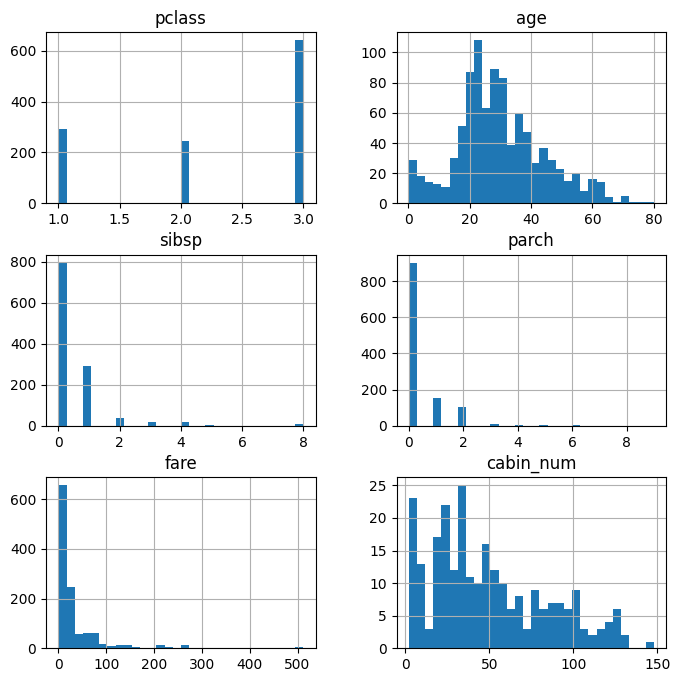

In [29]:
# numerique

X_train.select_dtypes(exclude='O').hist(bins=30, figsize=(8,8))
plt.show()

In [32]:
import sys
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m  pip install -U feature_engine
!{sys.executable} -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.0 MB/s eta 0:00:00m eta 0:00:010:01:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1


### Pipeline

In [40]:
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder

In [41]:

titanic_pipe = Pipeline([

    # imputation de données manquantes
    ('imputer_num',
     ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['age', 'fare', 'cabin_num'])),
    ('imputer_cat',
     CategoricalImputer(variables=['embarked', 'cabin_cat'])),

    # encodage catégoriel
    ('encoder_rare_label',
     RareLabelEncoder(tol=0.01,
                                    n_categories=6,
                                    variables=['cabin_cat'])),
    ('categorical_encoder',
     OrdinalEncoder(encoding_method='ordered',
                                  variables=['cabin_cat', 'sex', 'embarked'])),

    # Gradient Boosted machine
    ('gbm', GradientBoostingClassifier(random_state=0))
])

In [43]:
## Ajustons le pipeline et faisons des prédictions
titanic_pipe.fit(X_train, y_train)

X_train_preds = titanic_pipe.predict_proba(X_train)[:,1]
X_test_preds = titanic_pipe.predict_proba(X_test)[:,1]

In [44]:
## Un aperçu des valeurs de prédiction
X_train_preds

array([0.27876558, 0.08146821, 0.46816053, ..., 0.70745459, 0.90809699,
       0.4980871 ])

In [45]:
print('Train set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
GBM roc-auc: 0.9269576293912577
Test set
GBM roc-auc: 0.8396084337349397


In [46]:
importance = pd.Series(titanic_pipe.named_steps['gbm'].feature_importances_)
importance.index = data.drop('survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

<AxesSubplot: >